In [1]:
from functions import *
from runge_kutta import solve_runge_kutta
import matplotlib.pyplot as plt
import pickle

In [2]:
Qdim = 30
Qmax = 1.5
pulse_shape = 'gauss'
tdim = 100000
tmax = 10000
delta_t = tmax/tdim
qlist  = np.linspace(Qmax/Qdim, Qmax, Qdim)
tlist = np.linspace(delta_t, tmax, tdim)
V_kq = V_matrix(qlist)
n_wells = 1
z_2 = 500320
t_c = 3000
reflections = False
E_0 = 2*np.pi*hbar/d_cv*0.55
spacing_0 = 0

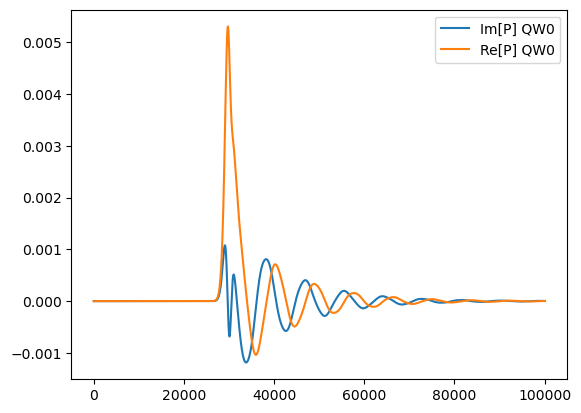

In [3]:

@jit(nopython = True)
def ddt_nonlinear_singlepulse_wrapper(t,y, chem_pot, T, n0_list):
    return ddt_nonlinear_singlepulse(t,y, n_wells, z_2, d_cv, V_kq, qlist = qlist, reflections = reflections, spacing_0 = spacing_0, shape = pulse_shape, t_c = t_c,E_0 = E_0)
#solve ODE
y0 = np.zeros(2*n_wells*Qdim, dtype = 'complex128')
Y = solve_runge_kutta(ddt_nonlinear_singlepulse_wrapper, tlist, y0)[0]

p_t_ = np.transpose(Y[:,:n_wells*Qdim])
n_t_ = np.transpose(Y[:,n_wells*Qdim:])
#print([p_t_[Qdim*i:Qdim*(i+i)] for i in range(n_wells)])
#print(n_t_.shape)
P_ts = [P(p_t_[Qdim*i:Qdim*(i+1)], tdim, d_cv = d_cv, qlist=qlist) for i in range(n_wells)]
N_ts = [N(n_t_[Qdim*i:Qdim*(i+1)], tdim, d_cv = d_cv, qlist=qlist) for i in range(n_wells)]
for i,pol in enumerate(P_ts):
    plt.plot(np.imag(pol), label = 'Im[P] QW{}'.format(i))
    plt.plot(np.real(pol), label = 'Re[P] QW{}'.format(i))
plt.legend()

#ft = fouriertrafo(P_t, omega_list, tlist)


#with open(r"results/Qmax={}_Qdim={}_tmax={}_singlepulse_spectra_MQW.pickle".format(Qmax, Qdim, tmax), 'wb') as output_file:
 #   pickle.dump(abs, output_file)

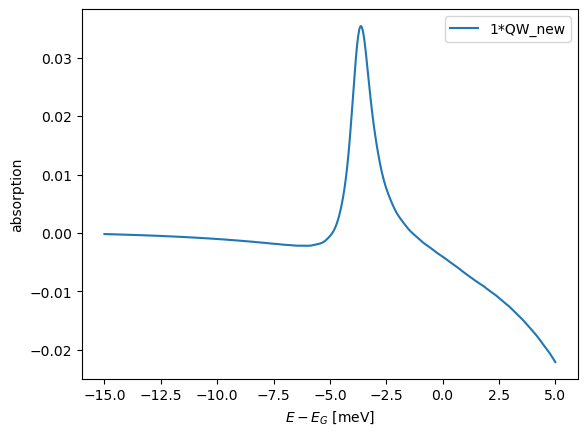

In [4]:
abs_new = get_absorption(P_list = P_ts, t_probe=t_c, reflections = reflections, E_probe = E_0, n_wells = n_wells, tlist=tlist,z_2 = 500320, spacing_0 = spacing_0, omega_list = omega_list, pulse_shape = pulse_shape)
#abs = get_absorption(P_list = P_ts_single, t_probe=t_c, reflections = reflections, n_wells = 1,tlist=tlist, omega_list = omega_list, pulse_shape = pulse_shape)
#plt.plot(1000* hbar*(omega_list- 0.012903883497007542), abs, label = '{}*QW'.format(1))
plt.plot(1000* hbar*(omega_list- 0.012903883497007542), abs_new, label = '{}*QW_new'.format(n_wells))
plt.xlabel(r'$E-E_G$ [meV]')
plt.ylabel('absorption')
plt.legend()
#plt.savefig('results/absorptions_singlepulse_MQW_Qmax={}_Qdim={}.pdf'.format(Qmax, Qdim))

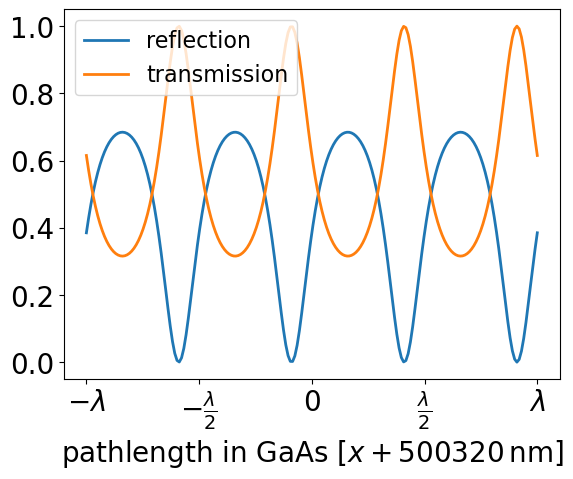

In [18]:
z_2 = 500320
z_low = z_2 - 2*np.pi*c/(omega_1*n_ref)
z_high = z_2 + 2*np.pi*c/(omega_1*n_ref)
z_2_list = np.linspace(z_low, z_high, 200)
reflection = []
transmission = []
E0_t = gauss_pulse(tlist, E_2, sigma=sigma2, t_center=t_c)
E0_w = fouriertrafo(E0_t,tlist=tlist,omega_list=omega_list)[325]
for z2 in z_2_list:
    R,T = reflection_transmission(E0_w = E0_w, reflections = True,z_2 = z2)
    reflection.append(R)
    transmission.append(T)
plt.rcParams.update({'font.size': 20})
ax = plt.axes() 
ax.set_xticks([z_low, (z_2+z_low)/2, z_2, (z_2+z_high)/2, z_high]) 
ax.set_xticklabels([r'$-\lambda$', r'$-\frac{\lambda}{2}$', r'$0$', r'$\frac{\lambda}{2}$', r'$\lambda$'])
plt.xlabel('pathlength in GaAs [$x+500320\,$nm]')
plt.plot(z_2_list,reflection, label='reflection', linewidth = 2)
plt.plot(z_2_list,transmission, label='transmission', linewidth = 2)
plt.legend(fontsize = 16)
plt.savefig('transmission_reflection_bare_field.pdf', bbox_inches='tight')

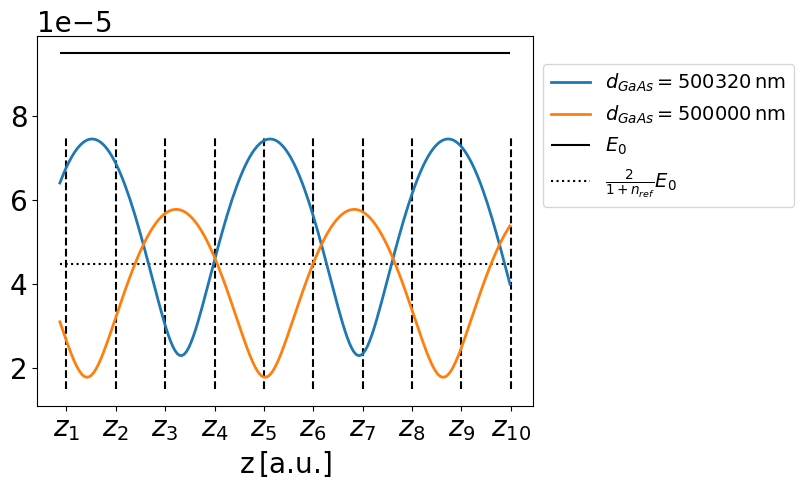

In [16]:
z_2 = [500320, 500000]
z_low = 0
z_high = 320
z_list = np.linspace(z_low, z_high, 200)
field = [[],[]]
E0_t = gauss_pulse(tlist, E_2, sigma=sigma2, t_center=t_c)
E0_w = fouriertrafo(E0_t,tlist=tlist,omega_list=omega_list)[325]
for i,z2 in enumerate(z_2):
    for z in z_list:
        field[i].append(np.abs(field_in_block(z,E0_w, z2)))

plt.rcParams.update({'font.size': 20})
ax = plt.axes() 
ax.set_xticks(np.linspace(4.6, 4.6+10*(7.6+4.6+19.4),10,endpoint = True)) 
ax.set_xticklabels([r'$z_1$', r'$z_2$', r'$z_3$',r'$z_4$',r'$z_5$',r'$z_6$',r'$z_7$',r'$z_8$',r'$z_9$',r'$z_{10}$'])
plt.xlabel(r'z$\,$[a.u.]')
for i,z2 in enumerate(z_2):
    plt.plot(z_list,field[i],label = r'$d_{GaAs} = %d\,$nm' % z2, linewidth = 2)
plt.vlines(np.linspace(4.6, 4.6+10*(7.6+4.6+19.4),10,endpoint = True), 1.5*10**(-5), 7.5*10**(-5), colors='black', linestyles='dashed')
plt.hlines(np.abs(E0_w),z_low,z_high, colors='black',label = r'$E_0$')
plt.hlines(2/(1+n_ref)*np.abs(E0_w),z_low,z_high, colors='black',linestyles = 'dotted',label = r'$\frac{2}{1+n_{ref}}E_0$')
plt.legend(fontsize = 14, bbox_to_anchor=(1,0.95))
plt.savefig('bare_field_inside.pdf', bbox_inches='tight')


In [26]:
Qdim = 10
Qmax = 0.1
pulse_shape = 'gauss'
tdim = 100000
tmax = 10000
delta_t = tmax/tdim
qlist  = np.linspace(Qmax/Qdim, Qmax, Qdim)
tlist = np.linspace(delta_t, tmax, tdim)
V_kq = V_matrix(qlist)
n_wells = 1
z_2 = 500320
t_c = 3000
reflections = False
E_0 = 2*np.pi*hbar/d_cv*0.55
spacing_0 = 0

In [27]:
n_wells = 1
@jit(nopython = True)
def ddt_nonlinear_singlepulse_wrapper(t,y, chem_pot, T, n0_list):
    return ddt_nonlinear_singlepulse(t,y, n_wells, z_2, d_cv, V_kq, spacing_0 = 0, qlist = qlist, reflections = False, shape = pulse_shape, t_c = t_c,E_0 = E_0)
#solve ODE
y0 = np.zeros(2*n_wells*Qdim, dtype = 'complex128')
Y = solve_runge_kutta(ddt_nonlinear_singlepulse_wrapper, tlist, y0)[0]

p_t_ = np.transpose(Y[:,:n_wells*Qdim])
n_t_ = np.transpose(Y[:,n_wells*Qdim:])
#print([p_t_[Qdim*i:Qdim*(i+i)] for i in range(n_wells)])
#print(n_t_.shape)
P_ts_single = [P(p_t_[Qdim*i:Qdim*(i+1)], tdim, d_cv = d_cv, qlist=qlist) for i in range(n_wells)]
N_ts_single = [N(n_t_[Qdim*i:Qdim*(i+1)], tdim, d_cv = d_cv, qlist=qlist) for i in range(n_wells)]

@jit(nopython = True)
def ddt_nonlinear_singledir_wrapper(t,y, chem_pot, T, n0_list):
    return ddt_nonlinear_singledir(t,y,V_kq, qlist = qlist,  shape = pulse_shape, t_c = t_c, E_0 = E_0)
#solve ODE
y0 = np.zeros(2*n_wells*Qdim, dtype = 'complex128')
Y1 = solve_runge_kutta(ddt_nonlinear_singledir_wrapper, tlist, y0)[0]

p_t_1 = np.transpose(Y1[:,:n_wells*Qdim])
n_t_1 = np.transpose(Y1[:,n_wells*Qdim:])
#print([p_t_[Qdim*i:Qdim*(i+i)] for i in range(n_wells)])
#print(n_t_.shape)
P_ts_1 = P(p_t_1[0:Qdim*(1)], tdim, d_cv = d_cv, qlist=qlist)
N_ts_1 = N(n_t_1[0:Qdim*(1)], tdim, d_cv = d_cv, qlist=qlist)

n0_list = np.zeros(Qdim)
@jit(nopython = True)
def ddt_nonlinear_manual_wrapper(t,y, chem_pot, T, n0_list):
    return ddt_nonlinear_manual(t,y, chem_pot, T, n0_list, V_kq, E_pump = 0, E_probe = E_0, t_probe = t_c, t_pump = t_c, qlist = qlist, Q_eqrange = Q_eqrange, intraband_rel=False ,pump_detuning = 0)
tspan = np.array([0,tmax])
p0 = np.zeros(5*Qdim, dtype = 'complex128')
#Y_nonlinear = solve_ivp(lambda t, y: ddt_nonlinear_manual(t, y, pump_strength, E_2, delta_t), tspan, p0, t_eval = tlist, method = 'DOP853', rtol = 1e-4, atol = 1e-15)
Y_nonlinear, potlist, Tlist, n0_list = solve_runge_kutta(ddt_nonlinear_manual_wrapper, tlist, p0, chem_pot, T, n0_list)
#retrieve results from state vector

indices_p = [[2,-1],[1,0],[0,1]]
indices_n = [[-1,1],[0,0]]
#t = Y_nonlinear.t
#p_ts = [Y_nonlinear.y[i*Qdim:(i+1)*Qdim] for i in range(3)]
#n_ts = [Y_nonlinear.y[i*Qdim:(i+1)*Qdim] for i in range(3, 5)]
t = tlist
p_ts = [np.transpose(Y_nonlinear[:, i*Qdim:(i+1)*Qdim]) for i in range(3)]
n_ts = [np.transpose(Y_nonlinear[:, i*Qdim:(i+1)*Qdim]) for i in range(3, 5)]
P_ts = np.array([P(p_t_,  tdim, d_cv = d_cv, qlist=qlist) for p_t_ in p_ts])
N_ts = np.array([N(n_t_, tdim, d_cv = d_cv, qlist=qlist) for n_t_ in n_ts])



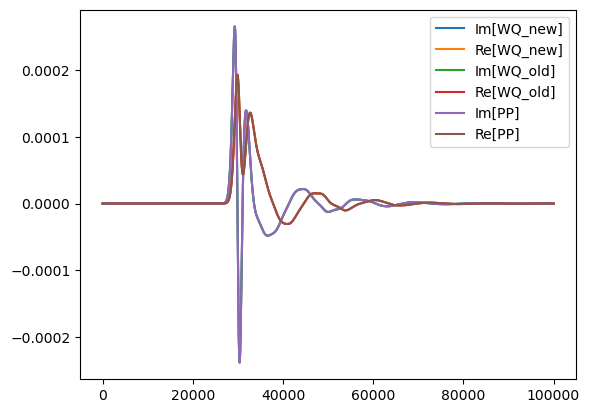

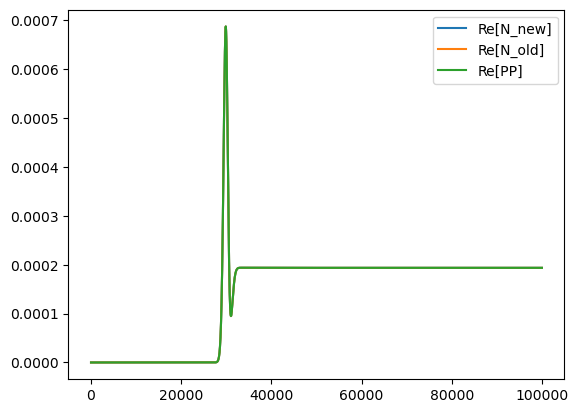

In [28]:

for i,pol in enumerate(P_ts_single):
    plt.plot(np.imag(pol), label = 'Im[WQ_new]')
    plt.plot(np.real(pol), label = 'Re[WQ_new]')
plt.plot(np.imag(P_ts_1), label = 'Im[WQ_old]')
plt.plot(np.real(P_ts_1), label = 'Re[WQ_old]')
plt.plot(np.imag(P_ts[2]), label = 'Im[PP]')
plt.plot(np.real(P_ts[2]), label = 'Re[PP]')
#plt.plot(np.abs(P_ts_1-P_ts_single[0]), label = 'diff')
plt.legend()
plt.show()
for i,occ in enumerate(N_ts_single):
 #   plt.plot(np.imag(occ), label = 'Im[N_new]')
    plt.plot(np.real(occ), label = 'Re[N_new]')
#plt.plot(np.imag(N_ts_1), label = 'Im[N_old]')
plt.plot(np.real(N_ts_1), label = 'Re[N_old]')
#plt.plot(np.imag(N_ts[1]), label = 'Im[PP]')
plt.plot(np.real(N_ts[1]), label = 'Re[PP]')
#plt.plot(np.abs(P_ts_1-P_ts_single[0]), label = 'diff')
plt.legend()
plt.show()


In [22]:
abs = get_absorption(P_list = P_ts_single,E_probe = E_0, t_probe=t_c,spacing_0 = spacing_0, reflections = False, n_wells = n_wells, tlist=tlist, omega_list = omega_list, pulse_shape = pulse_shape)
abs_old = get_spectrum(P_list = P_ts[2], t_probe=t_c,tlist=tlist, E_probe = E_0, omega_list = omega_list, pulse_shape = pulse_shape)

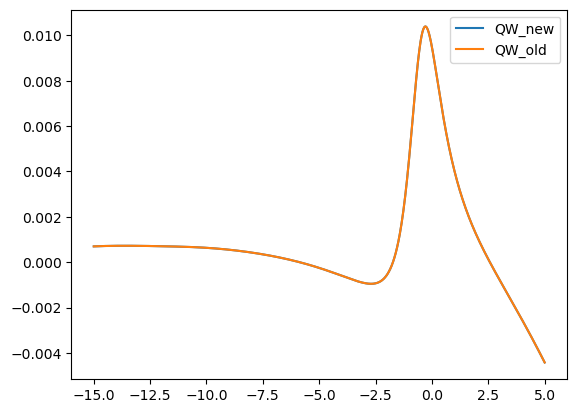

In [23]:
plt.plot(1000* hbar*(omega_list- 0.012903883497007542), abs, label = 'QW_new')
plt.plot(1000* hbar*(omega_list- 0.012903883497007542), abs_old, label = 'QW_old')
plt.legend()

In [19]:
with open('results/Qdim=700_Qmax=1.5_d_cv0.87_E00.00002_n_wells1_z2500320.0_reflectionsTrue_linear_grid_polarizations_MQW.pickle', 'rb') as input_file:
    P_ts = pickle.load(input_file)
abs = get_absorption(P_list = P_ts, t_probe=3000, E_probe = 2*np.pi*hbar/d_cv*0.00002, z_2 = 500320, reflections = True, sigma_probe = sigma2, n_wells = 1,tlist=tlist, omega_list = omega_list, pulse_shape = 'gauss')
#abs_old = get_spectrum(P_list = P_ts[0], t_probe=3000,E_probe = 2*np.pi*hbar/d_cv*0.00002,tlist=tlist, omega_list = omega_list, pulse_shape = pulse_shape)

FileNotFoundError: [Errno 2] No such file or directory: 'results/Qdim=700_Qmax=1.5_d_cv0.87_E00.00002_n_wells1_z2500320.0_reflectionsTrue_linear_grid_polarizations_MQW.pickle'

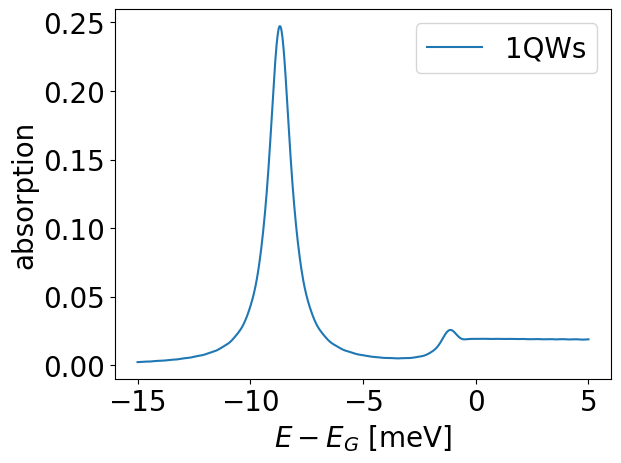

In [67]:
plt.plot(1000* hbar*(omega_list- 0.012903883497007542), abs, label = '{}QWs'.format(n_wells))
plt.xlabel(r'$E-E_G$ [meV]')
plt.ylabel('absorption')
plt.legend()
plt.savefig('results/Qdim=700_Qmax=1.5_d_cv0.87_E00.00002_n_wells1_z2500320.0_reflectionsTrue_linear_grid_absorption_singlepulse.pdf')

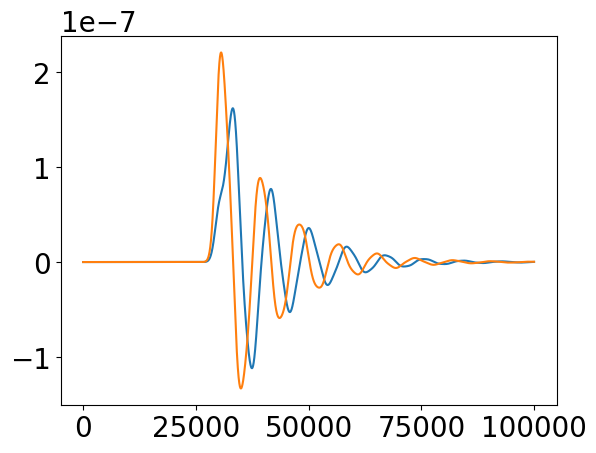

In [57]:
plt.plot(np.real(P_ts[0]), label = 'Re[P]')
plt.plot(np.imag(P_ts[0]), label = 'Im[P]')


In [ ]:
#time dynamics for single pulse
@jit(nopython = True)
def gamma_R(p_list, qlist):
    Qdim = len(qlist)
    dQ = qlist[1]-qlist[0]
    sum= 0
    for i in range(Qdim):
        sum +=p_list[i] *qlist[i] *dQ
    return sum *  d_cv**2 * (omega_1)/(2* epsilon_0*c*n_ref) *A/(2*np.pi)


@jit(nopython = True)
def ddt_nonlinear_singledir(t, y, V_kq, qlist = qlist, E_0=E_2, sigma = sigma2, t_c = t1, shape = 'gauss'):    
    #V_kq is a coulomb matrix of dimensions Qdim x Qdim
    #aufteilen der Zustands in p und n
    Qdim = len(qlist)
    p_list = y[:Qdim]
    n_list = y[Qdim:]

    #effektives Feld zur Zeit t berechnen
    if shape == 'sigma':
        E_eff = 1j*gamma_R(p_list,qlist) + d_cv * sigma_pulse(t, E_0=E_0, sigma = sigma, t_center = t_c)
    if shape == 'gauss':
        E_eff = 1j*gamma_R(p_list,qlist) + d_cv * gauss_pulse(t, E_0=E_0, sigma = sigma, t_center = t_c)
    #Ableitungsvektoren initialisieren
    dp = np.zeros(Qdim, dtype = 'complex128') 
    dn = np.zeros(Qdim, dtype = 'complex128') 

    #Diagonalbeiträge für P
    for i in range(Qdim):
        dp[i] -= 1j*(E_G/hbar - omega_2 + hbar * (0.5 / mu) * (qlist[i]**2) - 1j*gamma)* p_list[i] #Diagonalbeitrag
        for j in range(Qdim):
            dp[i]+= 2j/hbar*  V_kq[i][j] * n_list[j] * p_list[i] #n-Abhängigkeit 

    #Coulomb interaction und effektives E-Feld ergeben zusammen omega_R
        omega_R = 0
        for j in range(Qdim):
            omega_R += 1/hbar*  V_kq[i][j] * p_list[j]#Coulomb-interaction
        omega_R += 1/hbar* E_eff #Effektives E-Feld
    
    #Nebendiagonalen für p
        dp[i] -= 1j*omega_R * (2* n_list[i] - 1)
    #Nebendiagonalen für n
        dn[i] -= 2* np.imag(omega_R * np.conjugate(p_list[i]))
    return np.concatenate((dp,dn)),0,0,0

In [8]:
effective_field(0, [0.003+0.001j], 0.003+0.0004j, 1, 0, spacing_0 = 0)*d_cv -(1j*(0.003+0.001j)*d_cv*omega_1/(2*epsilon_0*c*n_ref) + d_cv*(0.003+0.0004j))

0j

In [15]:
n_ref

3.2526911934581184

In [7]:
for i in range(0,1):
    print(i)

0
